<a href="https://colab.research.google.com/github/jpatrickbouchet/land-cover-on-demand/blob/master/1_Preparing_ground_truth_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install geopandas
!pip install tensorflow==2.0.0-beta1

In [0]:
import os

# Data processing
import pandas as pd
import geopandas as gpd

# Data vizualisation
import matplotlib.pyplot as plt
import folium

# Tensorflow
import tensorflow as tf

In [0]:
# Authenticating to Google Cloud
from google.colab import auth
auth.authenticate_user()

In [0]:
BUCKET = 'BUCKET NAME HERE'
PROJECT = 'PROJECT ID HERE'
REGION = 'europe-west2'

In [0]:
# Setting environment variables
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [0]:
BUCKET_DIR = "gs://{0}/geodata".format(BUCKET)

## Downloading Corine Land Cover 2018 geopackage

**1. Go to the url below and request geopackage**  
https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download

**2. Copy the download link**

**3. Download the geopackage zip file locally

In [0]:
!curl [YOUR_URL_HERE] --output corine_land_cover_2018.zip

In [0]:
%%shell
unzip -n corine_land_cover_2018.zip -d .
rm corine_land_cover_2018.zip
unzip -n clc2018_clc2018_v2018_20_geoPackage.zip -d .
mv clc2018_clc2018_v2018_20_geoPackage corine_land_cover_2018

Archive:  clc2018_clc2018_v2018_20_geoPackage.zip
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/CLC2018_CLC2018_V2018_20.gpkg  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/CLC_country_coverage_v20.pdf  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/How use ESRI FGDB in QGIS.doc  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/readme_CLC2018_CLC2018_V2018_20.txt  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/readme_V20.txt  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Naming_convention_description.txt  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Metadata/CLC2018_CLC2018_V2018_20_FR_REU.xml  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Metadata/CLC2018_CLC2018_V2018_20.xml  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Metadata/CLC2018_CLC2018_V2018_20_FR_GLP.xml  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Metadata/CLC2018_CLC2018_V2018_20_FR_GUF.xml  
  inflating: ./clc2018_clc2018_v2018_20_geoPackage/Metadata/CLC2018_CLC20

In [0]:
## Copying extracted files to Google Cloud Storage for easy access later

%%shell
gsutil -m cp -r corine_land_cover_2018/* gs://${BUCKET}/corine_land_cover_2018/

Copying file://clc2018_clc2018_v2018_20_geoPackage/CLC2018_CLC2018_V2018_20.gpkg [Content-Type=application/octet-stream]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/How use ESRI FGDB in QGIS.doc [Content-Type=application/msword]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/clc_legend.qml [Content-Type=application/octet-stream]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/CLC_country_coverage_v20.pdf [Content-Type=application/pdf]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/clc_legend.sld [Content-Type=application/octet-stream]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/CLC_legend.csv [Content-Type=text/csv]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/clc_legend.txt [Content-Type=text/plain]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/clc_legend_qgis.txt [Content-Type=text/plain]...
Copying file://clc2018_clc2018_v2018_20_geoPackage/Legend/clc_legend.dbf [Content-Type=application/octe

## Loading Area Of Interest

I defined my area of interest in a geojson file, which I created using this nice little tool: [geojson.io](https://geojson.io)

I also made sure to create 3 geometries:  

*   1 for the entire area
*   1 for training
*   1 for validation


I tried to make the split between the training and validation area roughly 80% / 20%

Regarding the location of the area itself. I picked somewhere near my hometown (Orléans in France).  
I found it quite motivating to experiment with data I'm connected to.

In [0]:
# Downloading the geojson file

%%shell
!curl [URL HERE] --output train_valid_area.geojson
!gsutil cp train_valid_area.geojson gs://${BUCKET}/geodata/

In [0]:
# Loading geojson file
path = os.path.join(BUCKET_DIR, 'train_valid_area.geojson')

with tf.io.gfile.GFile(path, 'rb') as geojson:
    training_area = gpd.read_file(geojson)

training_area.head()

,split,geometry
0,all_aoi,"POLYGON ((1.932220458984375 47.72177305487703,..."
1,train,"POLYGON ((1.932220458984375 47.80502669216753,..."
2,valid,"POLYGON ((1.932220458984375 47.72177305487703,..."


In [0]:
# Setting area of interest (45-loiret in my case)
all_aoi = training_area[training_area['split'] == 'all_aoi']
all_aoi

,split,geometry
0,all_aoi,"POLYGON ((1.932220458984375 47.72177305487703,..."


In [0]:
# Checking the current Coordinate Reference System (CRS)
print('Current Coordinate Reference System:')
print(all_aoi.crs)

Current Coordinate Reference System:
{'init': 'epsg:4326'}


Epsg 4326 corresponds to the World Geodetic System 1984, used in GPS

More info here:  
https://epsg.io/4326  
https://www.earthdatascience.org/workshops/gis-open-source-python/reproject-vector-data-in-python/

## Visualising the AOI

In [0]:
map1 = folium.Map(location=[47.744374,1.862480])

folium.GeoJson(
    training_area,
    name='geojson'
).add_to(map1)


folium.LayerControl().add_to(map1)

map1

## Dimensions of the area

After a few investigations and considering my AOI, I picked UTM 31N as my Coordinate Reference System (CRS) moving forward.

Few info here: https://spatialreference.org/ref/epsg/wgs-84-utm-zone-31n/


In [0]:
# Convert the CRS to UTM_31N
aoi_utm = all_aoi.to_crs({'init': 'epsg:32631'})

# Get the country's shape in polygon format
aoi_shape = aoi_utm.geometry.values.tolist()[-1]


AOI_WIDTH = aoi_shape.bounds[2] - aoi_shape.bounds[0]
AOI_HEIGHT = aoi_shape.bounds[3] - aoi_shape.bounds[1]

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(AOI_WIDTH,
                                                             AOI_HEIGHT))

Dimension of the area is 53037 x 43657 m2


## Estimating amount of patches to be generated


In [0]:
# Expected images size output
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Patch resolution in meter
RESOLUTION = 10

In [0]:
train_aoi = training_area[training_area['split'] == 'train']
train_aoi_utm = train_aoi.to_crs({'init': 'epsg:32631'})

# Get the country's shape in polygon format
train_aoi_shape = train_aoi_utm.geometry.values.tolist()[-1]


TRAIN_AOI_WIDTH = train_aoi_shape.bounds[2] - train_aoi_shape.bounds[0]
TRAIN_AOI_HEIGHT = train_aoi_shape.bounds[3] - train_aoi_shape.bounds[1]

In [0]:
TRAIN_COL = int(TRAIN_AOI_WIDTH / (IMG_WIDTH * RESOLUTION)) 
TRAIN_ROW = int(TRAIN_AOI_HEIGHT / (IMG_HEIGHT * RESOLUTION))
TRAIN_PATCHES = TRAIN_COL * TRAIN_ROW

TRAIN_PATCHES

260

In [0]:
valid_aoi = training_area[training_area['split'] == 'valid']
valid_aoi_utm = valid_aoi.to_crs({'init': 'epsg:32631'})

# Get the country's shape in polygon format
valid_aoi_shape = valid_aoi_utm.geometry.values.tolist()[-1]


VALID_AOI_WIDTH = valid_aoi_shape.bounds[2] - valid_aoi_shape.bounds[0]
VALID_AOI_HEIGHT = valid_aoi_shape.bounds[3] - valid_aoi_shape.bounds[1]

In [0]:
VALID_COL = int(VALID_AOI_WIDTH / (IMG_WIDTH * RESOLUTION)) 
VALID_ROW = int(VALID_AOI_HEIGHT / (IMG_HEIGHT * RESOLUTION))
VALID_PATCHES = VALID_COL * VALID_ROW

VALID_PATCHES

60

## Loading Corine Land Cover geodata

The main geopackage is quite big and contains data for all Europe.  
To make things more manageable, I load the data with my area of interest as bounding box using Geopandas.

In [0]:
%%shell
gsutil -m cp gs://${BUCKET}/corine_land_cover_2018/CLC2018_CLC2018_V2018_20.gpkg ./corine_land_cover_2018
gsutil -m cp gs://${BUCKET}/corine_land_cover_2018/Legend/CLC_legend.csv ./corine_land_cover_2018

In [0]:
path_landcover = os.path.join('corine_land_cover_2018', 'CLC2018_CLC2018_V2018_20.gpkg')

corine_land_cover = gpd.read_file(path_landcover, bbox=all_aoi)
corine_land_cover

,Code_18,Remark,Area_Ha,ID,geometry
0,511,None,31509.282266,EU-2356402,(POLYGON Z ((3720774.609999999 2787172.1999999...
1,311,None,145525.077547,EU-2357623,"(POLYGON Z ((3713406.560000001 2782897.27 0, 3..."
2,242,None,68.461378,EU-484217,(POLYGON Z ((3717521.640000001 2761776.5600000...
3,243,None,34.802025,EU-489333,"(POLYGON Z ((3718282.359999999 2763443.76 0, 3..."
4,243,None,37.124131,EU-489350,"(POLYGON Z ((3722901.68 2763690.74 0, 3722839 ..."
5,243,None,49.446401,EU-489355,(POLYGON Z ((3717083.380000001 2763371.0600000...
6,312,None,359.201593,EU-502171,"(POLYGON Z ((3722918.35 2761180.02 0, 3722916...."
7,312,None,25.401342,EU-502178,"(POLYGON Z ((3723092.710000001 2762361.33 0, 3..."
8,312,None,30.596985,EU-502186,"(POLYGON Z ((3722403.619999999 2762681.9 0, 37..."
9,312,None,25.393543,EU-502191,(POLYGON Z ((3720628.720000001 2762607.9499999...


In [0]:
# Current Coordinate Reference System (CRS)
print('Current Coordinate Reference System:')
print(corine_land_cover.crs)

Current Coordinate Reference System:
{'init': 'epsg:3035'}


In [0]:
# Converting CRS to EPSG:4326
# (required to be imported as asset in Google Earth Engine)
corine_land_cover = corine_land_cover.to_crs({'init': 'epsg:4326'})

In [0]:
corine_land_cover.dtypes

Code_18      object
Remark       object
Area_Ha     float64
ID           object
geometry     object
dtype: object

In [0]:
# Converting Code_18 column from string to int64
# This is needed to filter the data in the next steps
corine_land_cover['Code_18'] = corine_land_cover['Code_18'].astype('int64')

## Loading Corine Land Cover legend data

In [0]:
path_legend = os.path.join('corine_land_cover_2018',
                           'Legend/CLC_legend.csv')

legend = pd.read_csv(path_legend, delimiter=';')
legend

,GRID_CODE,CLC_CODE,LABEL3,RGB
0,1,111,Continuous urban fabric,230-000-077
1,2,112,Discontinuous urban fabric,255-000-000
2,3,121,Industrial or commercial units,204-077-242
3,4,122,Road and rail networks and associated land,204-000-000
4,5,123,Port areas,230-204-204
5,6,124,Airports,230-204-230
6,7,131,Mineral extraction sites,166-000-204
7,8,132,Dump sites,166-077-000
8,9,133,Construction sites,255-077-255
9,10,141,Green urban areas,255-166-255


## Filtering the data

For this project, I wanted to segment everything in relation to agriculture and forest.  
Looking at the legend.csv file, these areas correspond to all GRID_CODEs from 12 to 26.

In [0]:
# Create a GRID_CODE / CLC_CODE mapping for this selection.
# I need it to filter the geopackage data since it only has CLC_CODEs

selected_codes = legend[
    legend['GRID_CODE'].isin(list(range(12,27)))][['GRID_CODE','CLC_CODE','LABEL3']] \
    .reset_index(drop=True)

selected_codes

,GRID_CODE,CLC_CODE,LABEL3
0,12,211,Non-irrigated arable land
1,13,212,Permanently irrigated land
2,14,213,Rice fields
3,15,221,Vineyards
4,16,222,Fruit trees and berry plantations
5,17,223,Olive groves
6,18,231,Pastures
7,19,241,Annual crops associated with permanent crops
8,20,242,Complex cultivation patterns
9,21,243,"Land principally occupied by agriculture, with..."


In [0]:
# Export the labels into a csv file for future use
labels = selected_codes[['GRID_CODE','LABEL3']].copy().reset_index(drop=True)
labels.loc[len(labels)] = [-1, 'Other land surface']
labels.to_csv('labels.csv', index=True, index_label='LABEL_ID', encoding='utf-8')

In [0]:
# And copy it to GCS bucket
%%shell
gsutil -m cp labels.csv gs://${BUCKET}/geodata/

Copying file://labels.csv [Content-Type=text/csv]...
/ [1/1 files][  515.0 B/  515.0 B] 100% Done                                    
Operation completed over 1 objects/515.0 B.                                      


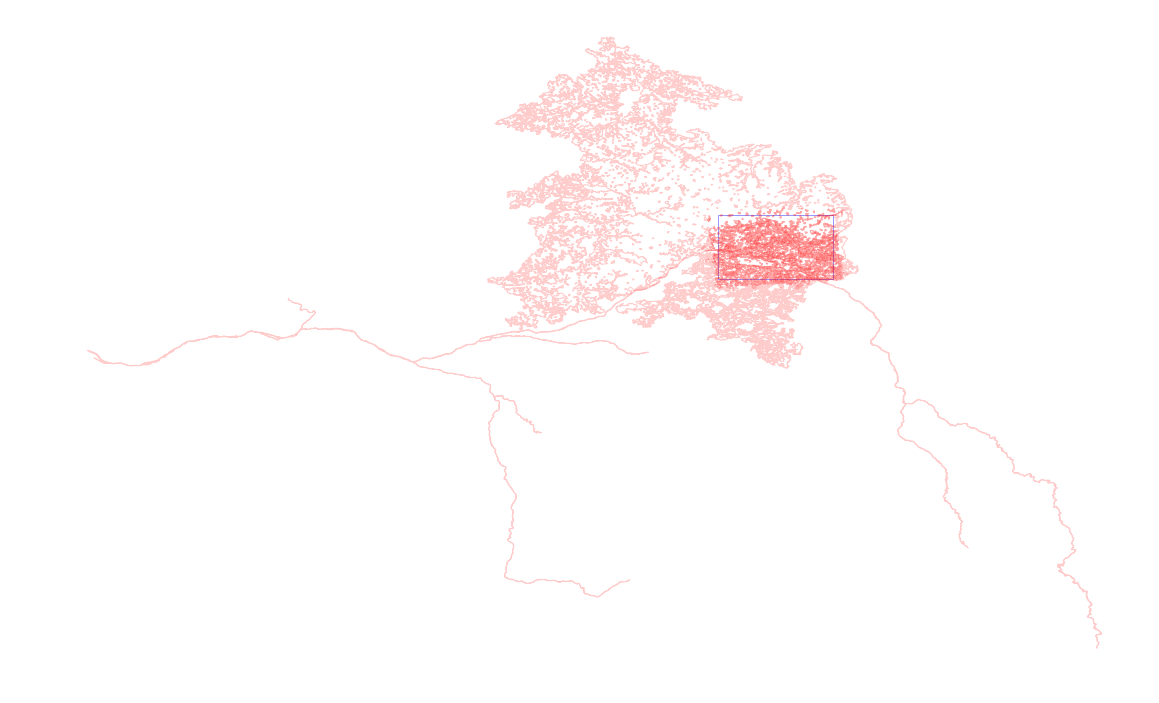

In [0]:
# Visualise the selection and AOI for confirmaton
# NOTE: The land cover still goes beyond the AOI
# since Geopandas doesn't cut geometries when applying
# a bounding box

fig, ax = plt.subplots(figsize=(20, 20))
all_aoi.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
corine_land_cover.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.2)

plt.axis('off');

## Assigning each class (land type) a label number starting from 0

This is required to train the model later on.

Selected classes are given a label from 0 to n_classes-1 (i.e. 0 to 14 in this case)  
Non selected land types are all given label n_classes (i.e. 15)

In [0]:
# Create a mapping as a dictionnary

all_clc_codes = legend.CLC_CODE.unique()
selected_clc_codes = selected_codes['CLC_CODE'].to_list()


selected_codes_map = {clc_code : index for index, clc_code
                      in enumerate(selected_clc_codes)}

other_codes_map = {clc_code : len(selected_clc_codes)
                   for clc_code in all_clc_codes
                   if clc_code not in selected_clc_codes}

clc_codes_map = {**selected_codes_map, **other_codes_map}
clc_codes_map

{111: 15,
 112: 15,
 121: 15,
 122: 15,
 123: 15,
 124: 15,
 131: 15,
 132: 15,
 133: 15,
 141: 15,
 142: 15,
 211: 0,
 212: 1,
 213: 2,
 221: 3,
 222: 4,
 223: 5,
 231: 6,
 241: 7,
 242: 8,
 243: 9,
 244: 10,
 311: 11,
 312: 12,
 313: 13,
 321: 14,
 322: 15,
 323: 15,
 324: 15,
 331: 15,
 332: 15,
 333: 15,
 334: 15,
 335: 15,
 411: 15,
 412: 15,
 421: 15,
 422: 15,
 423: 15,
 511: 15,
 512: 15,
 521: 15,
 522: 15,
 523: 15,
 990: 15,
 995: 15,
 999: 15}

In [0]:
corine_land_cover['LABEL_ID'] = corine_land_cover['Code_18'].map(clc_codes_map)
corine_land_cover

,Code_18,Remark,Area_Ha,ID,geometry,LABEL_ID
0,511,None,31509.282266,EU-2356402,(POLYGON Z ((1.958044399122833 47.903869256534...,15
1,311,None,145525.077547,EU-2357623,(POLYGON Z ((1.866135785508309 47.858419957190...,11
2,242,None,68.461378,EU-484217,(POLYGON Z ((1.950644859739082 47.673696231240...,8
3,243,None,34.802025,EU-489333,(POLYGON Z ((1.9583809002983 47.68934246099338...,9
4,243,None,37.124131,EU-489350,(POLYGON Z ((2.019244898723197 47.696046051047...,9
5,243,None,49.446401,EU-489355,(POLYGON Z ((1.942597702613787 47.687520152228...,9
6,312,None,359.201593,EU-502171,(POLYGON Z ((2.022963174198414 47.673616977052...,12
7,312,None,25.401342,EU-502178,(POLYGON Z ((2.02362824517368 47.6843466380223...,12
8,312,None,30.596985,EU-502186,(POLYGON Z ((2.01405154969633 47.6865443062102...,12
9,312,None,25.393543,EU-502191,(POLYGON Z ((1.990638991050072 47.684158749549...,12


In [0]:
!mkdir land_cover_training
corine_land_cover.to_file("land_cover_training/land_cover_training.shp")

In [0]:
%%shell
gsutil -m cp -r land_cover_training/* gs://${BUCKET}/geodata/land_cover_training/

Copying file://land_cover_training/land_cover_training.cpg [Content-Type=application/octet-stream]...
Copying file://land_cover_training/land_cover_training.dbf [Content-Type=application/octet-stream]...
Copying file://land_cover_training/land_cover_training.prj [Content-Type=application/octet-stream]...
Copying file://land_cover_training/land_cover_training.shp [Content-Type=application/x-qgis]...
Copying file://land_cover_training/land_cover_training.shx [Content-Type=application/x-qgis]...
\
Operation completed over 5 objects/6.2 MiB.                                      


## Upload land cover data to Google Earth Assets

Authentication reference:
https://developers.google.com/earth-engine/service_account

In [0]:
!pip install earthengine-api
!earthengine authenticate

In [0]:
# Import the Earth Engine API and initialize it.
import ee
ee.Initialize()

In [0]:
import time

taskId = ee.data.newTaskId()
shapeFilePath = "gs://{0}/geodata/land_cover_training/land_cover_training.shp".format(BUCKET)

params = {
    "id": "users/jpbouchet/land_cover_training",
    "sources": [{ "primaryPath": shapeFilePath, "charset": "UTF-8" }]
}

landcoverTask = ee.data.startTableIngestion(taskId[0], params)

print('Uploading and creating asset')

while ee.data.getTaskStatus(taskId)[0]['state'] != 'COMPLETED':
    print('.')
    time.sleep(5)

print('Task completed')

Uploading and creating asset
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Task completed
